In [1]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylhe
import pyslha
import xml.etree.ElementTree as ET
import seaborn as sns


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi": 300}) #Figure resolution

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family': 'Times New Roman', 'font.serif': 'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
events_path = '../MG5/DMSimp_Axial_monojet/Events/'
inputFiles = {'files1': {'noBias': events_path+'run_01/unweighted_events.lhe.gz',
                         'pT150 cut': events_path+'run_02/unweighted_events.lhe.gz',
                         'pT150 bias': events_path+'run_03/unweighted_events.lhe.gz'},
              'files2': {'noBias': events_path+'run_04/unweighted_events.lhe.gz',
                         'pT150 cut': events_path+'run_05/unweighted_events.lhe.gz',
                         'pT150 bias': events_path+'run_06/unweighted_events.lhe.gz'},
              'files3': {'noBias': events_path+'run_07/unweighted_events.lhe.gz',
                         'pT150 cut': events_path+'run_08/unweighted_events.lhe.gz',
                         'pT150 bias': events_path+'run_09/unweighted_events.lhe.gz'},
              'files4': {'noBias': events_path+'run_13/unweighted_events.lhe.gz',
                         'pT150 cut': events_path+'run_14/unweighted_events.lhe.gz',
                         'pT150 bias': events_path+'run_15/unweighted_events.lhe.gz'},
              'files5': {'noBias': events_path+'run_16/unweighted_events.lhe.gz',
                         'pT150 cut': events_path+'run_17/unweighted_events.lhe.gz',
                         'pT150 bias': events_path+'run_18/unweighted_events.lhe.gz'},
              'files6': {'noBias': events_path+'run_19/unweighted_events.lhe.gz',
                         'pT150 cut': events_path+'run_20/unweighted_events.lhe.gz',
                         'pT150 bias': events_path+'run_21/unweighted_events.lhe.gz'},}

In [3]:
# Read events and number of events
eventsTot, neventsTot = {}, {}

for key, files in inputFiles.items():
    eventDict, neventsDict = {}, {}
    for label, file in files.items():
        eventDict[label] = pylhe.read_lhe_with_attributes(file)
        neventsDict[label] = pylhe.read_num_events(file)
        
    eventsTot[key] = eventDict
    neventsTot[key] = neventsDict

In [4]:
# Obtain parameters from banner.txt file
parametersDict, parameters = {}, {}

for key, files in inputFiles.items():
    for label, file in files.items():
        banner = list(glob.glob(os.path.dirname(file)+'/*banner.txt'))
        if len(banner) != 1:
            print('%i banner files found for %s' %(len(banner), label))
            break
        else:
            banner = banner[0]
            tree = ET.parse(banner)
            root = tree.getroot()
            slha = root.find('header').find('slha').text
            pars = pyslha.readSLHA(slha)
            mMed = pars.blocks['MASS'][55] # Mediator mass
            mDM = pars.blocks['MASS'][52] # Dark matter mass
            gVq = pars.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
            gAq = pars.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
            gVx = pars.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
            gAx = pars.blocks['DMINPUTS'][3] # Mediator-DM axial coupling
            parametersDict[label] = {'mMed': mMed, 'mDM': mDM,
                                 'gVq': gVq, 'gAq': gAq, 'gVx': gVx, 'gAx': gAx}
            print(label, ': mMed = %1.1f GeV, mDM = %1.1f GeV' %(mMed, mDM))
            
    parameters[key] = parametersDict[label]

noBias : mMed = 2000.0 GeV, mDM = 1.0 GeV
pT150 cut : mMed = 2000.0 GeV, mDM = 1.0 GeV
pT150 bias : mMed = 2000.0 GeV, mDM = 1.0 GeV
noBias : mMed = 2000.0 GeV, mDM = 900.0 GeV
pT150 cut : mMed = 2000.0 GeV, mDM = 900.0 GeV
pT150 bias : mMed = 2000.0 GeV, mDM = 900.0 GeV
noBias : mMed = 2000.0 GeV, mDM = 600.0 GeV
pT150 cut : mMed = 2000.0 GeV, mDM = 600.0 GeV
pT150 bias : mMed = 2000.0 GeV, mDM = 600.0 GeV
noBias : mMed = 100.0 GeV, mDM = 1.0 GeV
pT150 cut : mMed = 100.0 GeV, mDM = 1.0 GeV
pT150 bias : mMed = 100.0 GeV, mDM = 1.0 GeV
noBias : mMed = 500.0 GeV, mDM = 1.0 GeV
pT150 cut : mMed = 500.0 GeV, mDM = 1.0 GeV
pT150 bias : mMed = 500.0 GeV, mDM = 1.0 GeV
noBias : mMed = 1000.0 GeV, mDM = 1.0 GeV
pT150 cut : mMed = 1000.0 GeV, mDM = 1.0 GeV
pT150 bias : mMed = 1000.0 GeV, mDM = 1.0 GeV


In [5]:
# Setting cuts
pt_min = 100.
ptj_min = 25.
eta_max = 2.4
met_min = 250.

In [6]:
pt_jet = {key : {label : np.array([]) for label in files} for key, files in inputFiles.items()}
njets = {key : {label : np.array([]) for label in files} for key, files in inputFiles.items()}
met = {key : {label : np.array([]) for label in files} for key, files in inputFiles.items()}
weights = {key : {label : np.array([]) for label in files} for key, files in inputFiles.items()}
totalweight = {key : {label : 0 for label in files} for key, files in inputFiles.items()}

for k, events in eventsTot.items():
    for label, evts in events.items():
        nevents = neventsTot[k][label]
        parameters[k]['Events'] = nevents
        
        for event in evts:
            
            jets = [p for p in event.particles if abs(p.id) in [1,2,3,4,5,21] and p.status==1]
            dm = [p for p in event.particles if abs(p.id) in [52] and p.status==1]
            
            if len(dm) != 2:
                continue
                
            weight = event.eventinfo.weight/nevents
            totalweight[k][label] += weight
            
            jet_list = []
            
            for j in jets: 
                pt = np.sqrt(j.px**2 + j.py**2)
                p = np.sqrt(j.px**2 + j.py**2 + j.pz**2)
                eta = 0.5*np.log((p + j.pz)/(p - j.pz))
                
                if pt < ptj_min:
                    continue
                if np.abs(eta) > eta_max:
                    continue
                jet_list.append(j)
            jet_list = sorted(jet_list, key=lambda j: np.sqrt(j.px**2 + j.py**2), reverse=True)
            
            met_tmp = np.sqrt((dm[0].px + dm[1].px)**2 + (dm[0].py + dm[1].py)**2)
            
            if len(jet_list) == 0:
                continue
                
            pt_tmp = np.sqrt(jet_list[0].px**2 + jet_list[0].py**2)
            
            if met_tmp < met_min:
                continue
            if pt_tmp < pt_min:
                continue
            
            
            pt_jet[k][label] = np.append(pt_jet[k][label], pt_tmp)
            met[k][label] = np.append(met[k][label], met_tmp)
            njets[k][label] = np.append(njets[k][label], len(jets))
            weights[k][label] = np.append(weights[k][label], weight)

In [7]:
for key, weight in totalweight.items():
    for label, w in weight.items():
        print(key+':', label, 'total cross section = %1.3e pb' %w)

files1: noBias total cross section = 2.625e-01 pb
files1: pT150 cut total cross section = 4.526e-02 pb
files1: pT150 bias total cross section = 2.633e-01 pb
files2: noBias total cross section = 3.354e-02 pb
files2: pT150 cut total cross section = 6.113e-03 pb
files2: pT150 bias total cross section = 3.348e-02 pb
files3: noBias total cross section = 1.518e-01 pb
files3: pT150 cut total cross section = 2.745e-02 pb
files3: pT150 bias total cross section = 1.510e-01 pb
files4: noBias total cross section = 6.977e+03 pb
files4: pT150 cut total cross section = 1.049e+02 pb
files4: pT150 bias total cross section = 6.972e+03 pb
files5: noBias total cross section = 6.961e+01 pb
files5: pT150 cut total cross section = 6.980e+00 pb
files5: pT150 bias total cross section = 6.897e+01 pb
files6: noBias total cross section = 5.614e+00 pb
files6: pT150 cut total cross section = 7.920e-01 pb
files6: pT150 bias total cross section = 5.552e+00 pb


In [8]:
colors = {k: {label: sns.color_palette('colorblind')[i+1] for i,label in enumerate(weights[k].keys())}
          for k in weights}
labels = ['noBias', 'pT150 cut', 'pT150 bias']

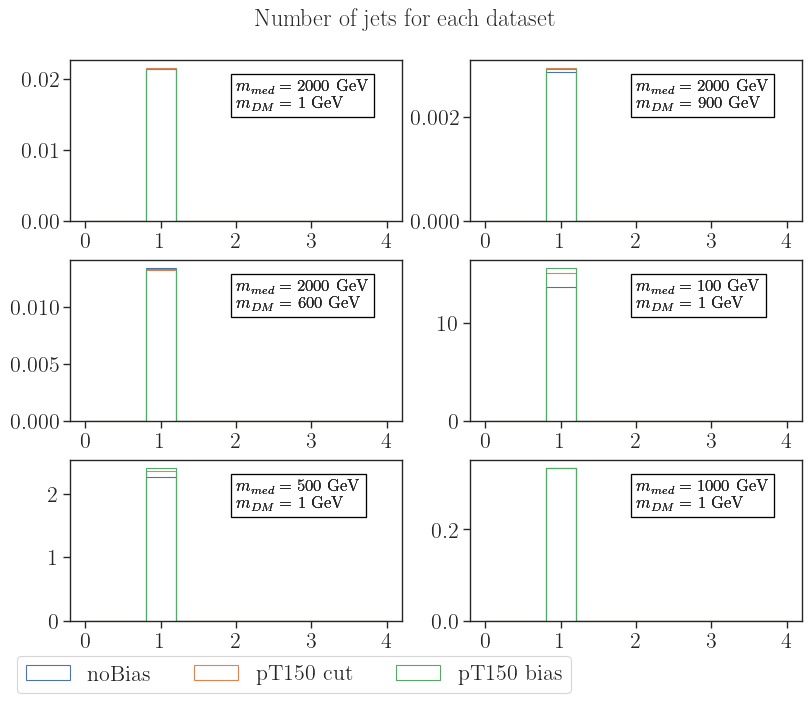

In [9]:
# Vefiry number of jets
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), constrained_layout=True)
ax = ax.flatten()

row=0

for key in njets.keys():
    for label in njets[key].keys():
        ax[row].hist(njets[key][label], bins=np.linspace(0,4,11), histtype='step', 
                     weights=weights[key][label])
        
        textstr = '\n'.join((r'$m_{med} =$ %1.0f GeV' %parameters[key]['mMed'], 
                             r'$m_{DM} =$ %1.0f GeV' %parameters[key]['mDM']))
        ax[row].text(0.5,0.7,textstr,fontsize='x-small',bbox=dict(facecolor='none', edgecolor='black'),
                     transform = ax[row].transAxes)
        
    row +=1


fig.legend(labels, loc='lower left', bbox_to_anchor=(0,-0.08), ncol=len(labels), bbox_transform=fig.transFigure)
fig.text(0.5, 1.06, 'Number of jets for each dataset', ha='center', va='center') #title
plt.show()
            

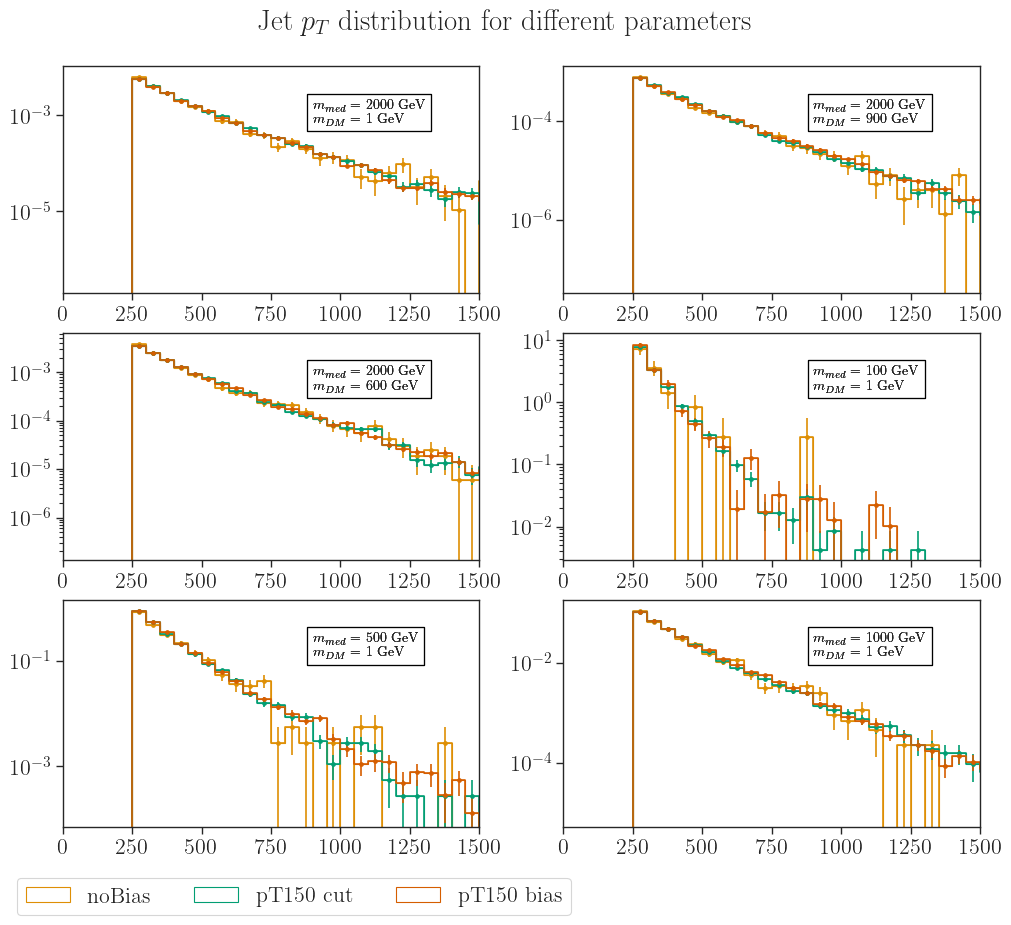

In [10]:
# Plot jt pt vs xsection
fig, ax = plt.subplots(3, 2, figsize=(10,8), constrained_layout=True)
ax = ax.flatten()
row=0

for key, ptDict in pt_jet.items():
    for label, pt in ptDict.items():
        binc, bin_edges, patches = ax[row].hist(pt, bins=np.linspace(0,5000,101), 
                                                histtype='step', weights=weights[key][label], 
                                                color=colors[key][label])
        errorc2, _ = np.histogram(pt, bins=bin_edges, weights=weights[key][label]**2)
        errorc = np.sqrt(errorc2)
        bin_center = (bin_edges[0:-1] + bin_edges[1:])/2.
        ax[row].errorbar(bin_center, binc, yerr=errorc, marker='.', drawstyle='steps-mid', 
                         color=colors[key][label])

        textstr = '\n'.join((r'$m_{med} =$ %1.0f GeV' %parameters[key]['mMed'], 
                             r'$m_{DM} =$ %1.0f GeV' %parameters[key]['mDM']))
        ax[row].text(0.6,0.75,textstr,fontsize='xx-small', bbox=dict(facecolor='none', edgecolor='black'),
                     transform = ax[row].transAxes)

        
        ax[row].set_yscale('log')
        ax[row].set_xlim(0, 1500)
    row += 1
    
fig.text(0.5, 1.05, r'Jet $p_{T}$ distribution for different parameters', 
         ha='center', va='center', fontsize='large') # title
fig.legend(labels, loc='lower left', bbox_to_anchor=(0,-0.08), ncol=len(labels), 
           bbox_transform=fig.transFigure)

plt.show()

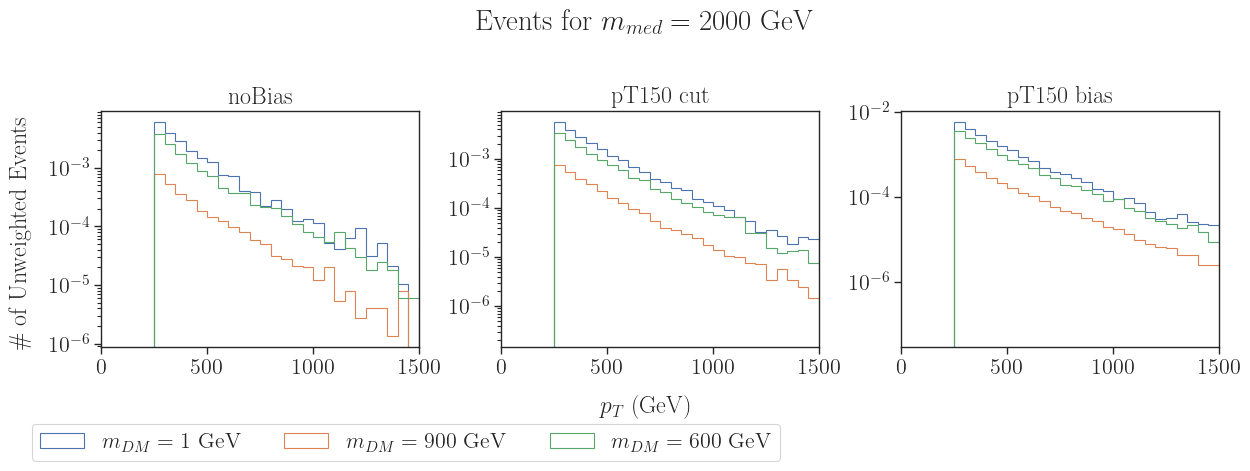

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,3), constrained_layout=True)
ax = ax.flatten()
row=0

for label in labels:
    for key in pt_jet.keys():
        if parameters[key]['mMed'] == 2000.:
            binc, bin_edges, patches = ax[row].hist(pt_jet[key][label], bins=np.linspace(0,5000,101), 
                                                    histtype='step', weights=weights[key][label]) # put weights      
            
            ax[row].set_yscale('log')
            ax[row].set_xlim(0,1500)
            ax[row].set_title(label)
            
    row +=1
    
legend=[r'$m_{DM} = 1$ GeV',r'$m_{DM} = 900$ GeV',r'$m_{DM} = 600$ GeV']

fig.legend(legend[:3], loc='lower left', bbox_to_anchor=(-.02,-0.3), ncol=len(labels), bbox_transform=fig.transFigure)
fig.text(0.5, 1.2, r'Events for $m_{med}=2000$ GeV', ha='center', va='center', fontsize='large') # title
fig.text(-.02, 0.5, '\# of Unweighted Events', ha='center', va='center', rotation='vertical') # y label
fig.text(0.5, -.08, r'$p_{T}$ (GeV)', ha='center', va='center') # x label
plt.show()

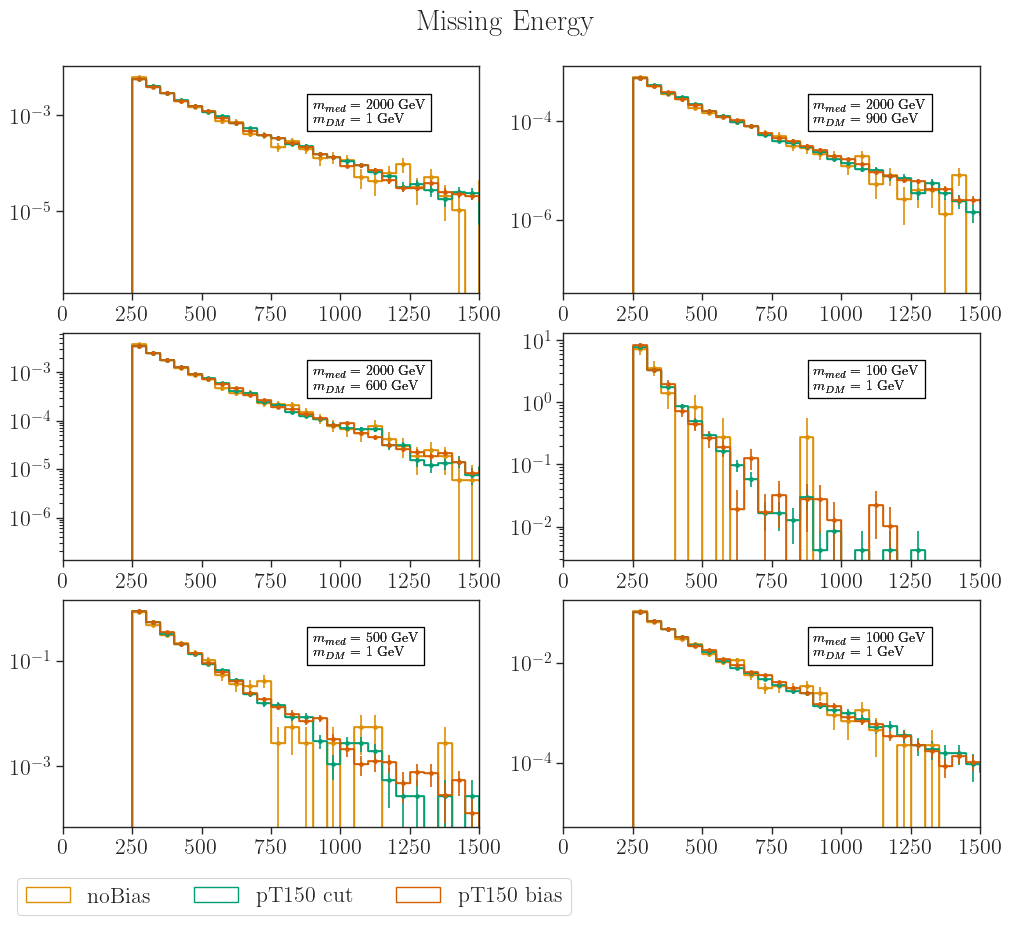

In [12]:
# Plot missing enegy
fig, ax = plt.subplots(3, 2, figsize=(10,8), constrained_layout=True)
ax = ax.flatten()
row=0

for key, metDict in met.items():
    for label, MET in metDict.items():
        binc, bin_edges, patches = ax[row].hist(MET, bins=np.linspace(0,5000,101), histtype='step',
                                           weights=weights[key][label], linewidth=1, color=colors[key][label])
        errorc2, _ = np.histogram(MET, bins=bin_edges, weights=weights[key][label]**2)
        errorc = np.sqrt(errorc2)
        bin_center = (bin_edges[0:-1] + bin_edges[1:])/2.
        ax[row].errorbar(bin_center, binc, yerr=errorc, marker='.', drawstyle='steps-mid', color=colors[key][label])
        
        textstr = '\n'.join((r'$m_{med} =$ %1.0f GeV' %parameters[key]['mMed'], 
                             r'$m_{DM} =$ %1.0f GeV' %parameters[key]['mDM']))
        ax[row].text(0.6,0.75,textstr,fontsize='xx-small', bbox=dict(facecolor='none', edgecolor='black'),
                     transform = ax[row].transAxes)
        ax[row].set_yscale('log')
        ax[row].set_xlim(0,1500)
        
        
    row += 1
    
fig.text(0.5, 1.05, r'Missing Energy', ha='center', va='center', fontsize='large') # title
fig.legend(labels, loc='lower left', bbox_to_anchor=(0,-0.08), ncol=len(labels), 
           bbox_transform=fig.transFigure)

plt.show()

In [13]:
# Compare to CMS data
cmsFile = './MonoXSMS-main/monoJet/CMS-EXO-20-004-data/Signaltemplates_DMsimp_spin-1_Monojet_DF.pcl'
df = pd.read_pickle(cmsFile)

In [14]:
dataset = 'files3'
mMed, mDM = parameters[dataset]['mMed'], parameters[dataset]['mDM']
if gAx:
    dfModel = df[(df['$m_{med}$'] == mMed) & (df['$m_{DM}$'] == mDM) 
                 & (df['Mode'] == 'DM+QCDjets') & (df['Data-takingperiod'] == 2017)
                 & (df['Coupling'] == 'Axial')]
elif gVx:
    dfModel = df[(df['$m_{med}$'] == mMed) & (df['$m_{DM}$'] == mDM) 
                 & (df['Mode'] == 'DM+QCDjets') & (df['Data-takingperiod'] == 2017)
                 & (df['Coupling'] == 'Vector')]

if len(dfModel) != 1:
    print('%i data rows selected' %(len(dfModel)))

In [15]:
bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if "bin_" in c and not 'Error' in c}
cmsData = {c : dfModel[c].iloc[0] for c in bins}
cmsErrors = {c : dfModel[c+'_ErrorPlus'].iloc[0] for c in bins}

rightBin = 2000.
binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()

# Plot CMS data
cmsValues = np.array(list(cmsData.values()))
cmsErrors = np.array(list(cmsErrors.values()))

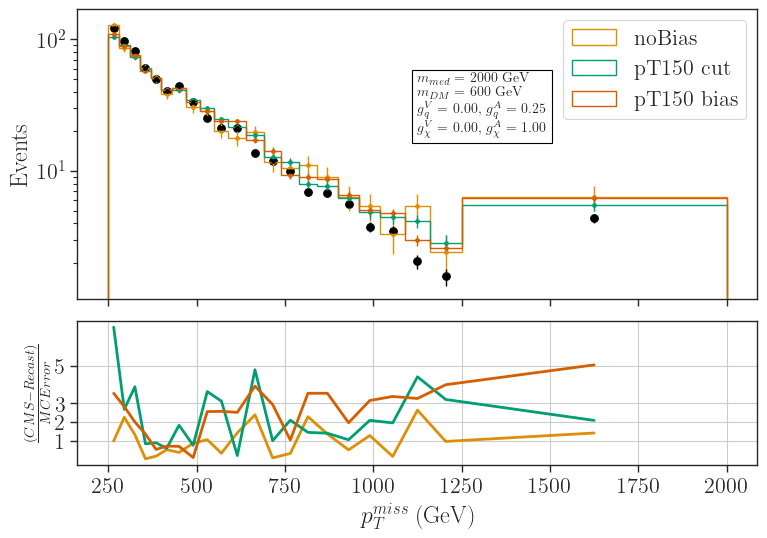

In [25]:
metDict, weight2, color2 = met[dataset], weights[dataset], colors[dataset]
 
lum2017 = 41.5 #fb^-1
kfactor = 1.2 # NLO (approx) k-factor
weightY = {label : w*1e3*lum2017*kfactor for label,w in weight2.items()} # weights for the Yield


f, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,6))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)


for label,metPts in metDict.items():
#     if label != 'noBias': continue
    # Plot MC bins
    binc,binEdges,_= ax[0].hist(metPts,bins=list(bins.values())+[rightBin],
                                   label=label,linewidth=1,
                                   weights=weightY[label],histtype='step',color=color2[label])
    errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weightY[label]**2)
    errorc = np.sqrt(errorc2)
    ax[0].errorbar(binCenter,binc,yerr = errorc, marker = '.', elinewidth=1.0,
                 drawstyle = 'steps-mid',color=color2[label],linewidth=0.0)

    
    relDiff = (binc-cmsValues)/cmsValues
    ratio = binc/cmsValues
    relDiffErr = np.abs(binc-cmsValues)/errorc
    #Plot ratio
    ax[1].plot(binCenter,relDiffErr,linewidth=2.0,color=color2[label])
    
    
# Plot CMS data
cmsValues = np.array(list(cmsData.values()))
ax[0].scatter(x=binCenter,y=cmsValues,s=30,c='black')
ax[0].errorbar(binCenter,cmsValues,yerr = cmsErrors, marker = '.', elinewidth=1.0,
                 drawstyle = 'steps-mid',color='black',linewidth=0.0)
ax[0].set_yscale('log')
ax[0].set_ylabel('Events')

ax[1].set_ylabel(r'$\frac{{(CMS-Recast)}}{{MC Error}}$', fontsize=14) #Y-label
ax[1].grid(True)
ax[1].set_xlabel(r'$p_{T}^{miss}$ (GeV)')
ax[1].set_yticks([1, 2, 3, 5])


textstr = '\n'.join((
    r'$m_{med} =$ %1.0f GeV' %mMed, 
    r'$m_{DM} =$ %1.0f GeV' %mDM,
    r'$g_{q}^{V}=$ %1.2f, $g_{q}^{A}=$ %1.2f' % (gVq, gAq),
    r'$g_{\chi}^{V}=$ %1.2f, $g_{\chi}^{A}=$ %1.2f' % (gVx, gAx)))
plt.text(0.5,2.3,textstr,fontsize=10,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
ax[0].legend()
# axarr[0].set_title('k-factor = %1.2f' %kfactor)
plt.show()

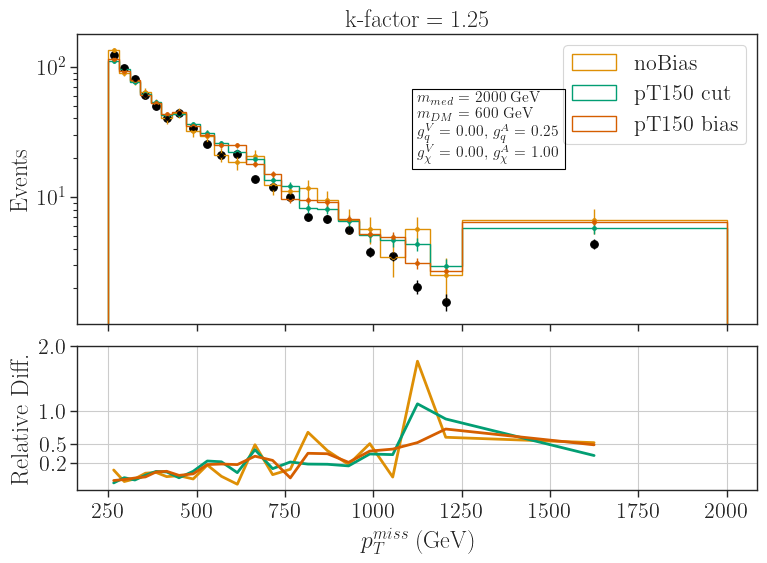

In [24]:
lum2017 = 41.5 #fb^-1
kfactor = 1.25 # NLO (approx) k-factor
weightY = {label : w*1e3*lum2017*kfactor for label,w in weight2.items()} # weights for the Yield


f, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,6))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

for label,metPts in metDict.items():
#     if label != 'noBias': continue
    # Plot MC bins
    binc,binEdges,_= ax[0].hist(metPts,bins=list(bins.values())+[rightBin],
                                   label=label,linewidth=1.,
                                   weights=weightY[label],histtype='step',color=color2[label])
    errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weightY[label]**2)
    errorc = np.sqrt(errorc2)
    ax[0].errorbar(binCenter,binc,yerr = errorc, marker = '.', elinewidth=1.0,
                 drawstyle = 'steps-mid',color=color2[label],linewidth=0.0)

    
    relDiff = (binc-cmsValues)/cmsValues
    ratio = binc/cmsValues
    relDiffErr = np.abs(binc-cmsValues)/errorc
    #Plot ratio
#     axarr[1].plot(binCenter,relDiffErr,linewidth=3.0,color=colors[label])
    ax[1].plot(binCenter,relDiff,linewidth=2.0,color=color2[label])
    
    
# Plot CMS data
cmsValues = np.array(list(cmsData.values()))
ax[0].scatter(x=binCenter,y=cmsValues,s=30,c='black')
ax[0].errorbar(binCenter,cmsValues,yerr = cmsErrors, marker = '.', elinewidth=1.0,
                 drawstyle = 'steps-mid',color='black',linewidth=0.0)
ax[0].set_yscale('log')
ax[0].set_ylabel('Events')

ax[1].set_yticks([0.2, 0.5, 1, 2])


ax[1].set_ylabel('Relative Diff.', fontsize=18) #Y-label
ax[1].grid(True)
ax[1].set_xlabel(r'$p_{T}^{miss}$ (GeV)')

textstr = '\n'.join((
    r'$m_{med} =$ %1.0f GeV' %mMed, 
    r'$m_{DM} =$ %1.0f GeV' %mDM,
    r'$g_{q}^{V}=$ %1.2f, $g_{q}^{A}=$ %1.2f' % (gVq, gAq),
    r'$g_{\chi}^{V}=$ %1.2f, $g_{\chi}^{A}=$ %1.2f' % (gVx, gAx)))
plt.text(0.5,2.3,textstr,fontsize=11,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
ax[0].legend()
ax[0].set_title('k-factor = %1.2f' %kfactor)
plt.show()